# Correlation - CMAP Precipitation and ESPI Index

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from clim_utils import label_latlons

In [2]:
file_espi='/homes/jcampb8/data-shell/thesis/espi_1979-2019.nc'
ds_espi=xr.open_dataset(file_espi)
ds_espi

<xarray.Dataset>
Dimensions:  (time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
Data variables:
    espi     (time) float64 ...

#### Slice to match ESPI index time series to precipitation data set time series

In [3]:
ds_espi=ds_espi.sel(time=slice('1982-01-01','2018-12-01'))
ds_espi

<xarray.Dataset>
Dimensions:  (time: 444)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2018-12-01
Data variables:
    espi     (time) float64 -0.565 -0.648 -0.285 -0.457 ... 0.395 0.281 0.292

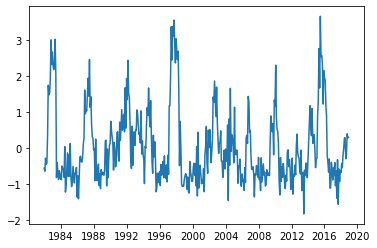

In [4]:
plt.plot(ds_espi['time'],ds_espi['espi'])

In [5]:
file='/homes/jcampb8/data-shell/thesis/enso4_1979-2018.cmap.monthly.precip.mon.mean.nc'
ds_precip=xr.open_dataset(file)
ds_precip

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36, time: 480)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (excludes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    References:     https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    version:        V1912
    history:        update 12/2019 V1912
    data_modified:  2019-12-12

In [6]:
# Slice time to match Nino data
ds_precip=ds_precip.sel(time=slice(ds_espi['time'][0],ds_espi['time'][-1]))

# Make anomalies
ds_climo=ds_precip.groupby('time.month').mean()
ds_anoms=ds_precip.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36, time: 444)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, lat, lon) float32 -0.119510144 -0.16511825 ... 0.4263096

Text(0, 0.5, 'Index/Anom Values')

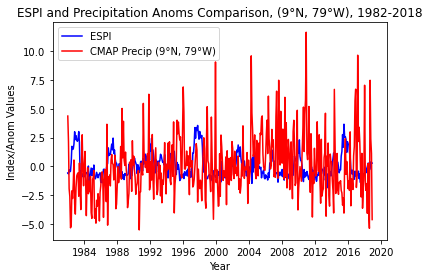

In [7]:
pt=ds_anoms.sel(lat=9,lon=360-79,method='nearest')
plt.plot(ds_espi['time'],ds_espi['espi'],'b')
plt.plot(pt['time'],pt['precip'],'r')
plt.legend(['ESPI','CMAP Precip (9°N, 79°W)'])
plt.title('ESPI and Precipitation Anoms Comparison, (9°N, 79°W), 1982-2018')
plt.xlabel('Year')
plt.ylabel('Index/Anom Values')

#### Calculate R values for correlation and then plot findings

In [8]:
R=np.corrcoef(ds_espi['espi'],pt['precip'])
R

array([[ 1.       , -0.1629729],
       [-0.1629729,  1.       ]])

In [9]:
corr=R[0,1]
corr

-0.16297289852743815

In [10]:
r_map=xr.corr(ds_espi['espi'],ds_anoms['precip'],dim='time')
r_map

<xarray.DataArray (lat: 32, lon: 36)>
array([[-0.02995426,  0.03586651,  0.05638185, ..., -0.07752065,
         0.06698846,  0.11472209],
       [-0.00234221,  0.10896301,  0.08624924, ..., -0.05528863,
         0.05389126,  0.03701595],
       [-0.02733066,  0.1195477 ,  0.0711797 , ..., -0.0340508 ,
         0.02580322,  0.0714725 ],
       ...,
       [ 0.49522729,  0.45168892,  0.44695503, ..., -0.14675397,
        -0.15576565, -0.19513304],
       [ 0.40796614,  0.37305434,  0.35102859, ..., -0.14853522,
        -0.13752824, -0.20056437],
       [ 0.35160057,  0.34674275,  0.32587022, ..., -0.13690634,
        -0.0332807 , -0.11366326]])
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75

Text(0.5, 1.0, 'Correlation between ESPI and Precipitation Anomalies')

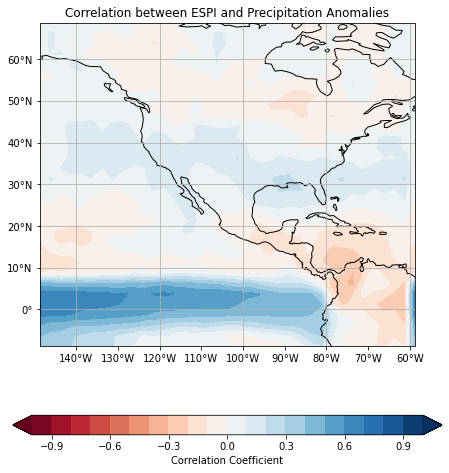

In [11]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=r_map
data,lon=add_cyclic_point(r_map,coord=ds_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='RdBu',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(220,310,10),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(0,70,10),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)


# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between ESPI and Precipitation Anomalies')

#### Find r,p, values

In [12]:
from scipy.stats import pearsonr

In [13]:
nx=len(ds_anoms['lon'])
ny=len(ds_anoms['lat'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))

for i in range(nx):
    for j in range(ny):
        r,p=pearsonr(ds_espi['espi'],ds_anoms['precip'][:,j,i])
        r_array[j,i]=r
        p_array[j,i]=p
r_array.shape

(32, 36)

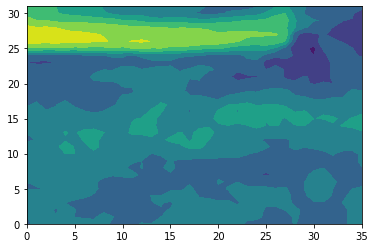

In [14]:
plt.contourf(r_array)

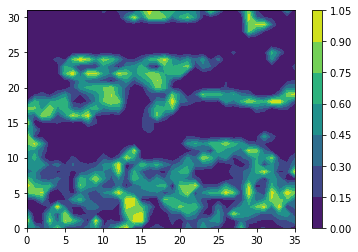

In [15]:
plt.contourf(p_array)
plt.colorbar()

#### Create a mask using `where` function to find p values less than 5% (0.05)

In [16]:
mask_sig=np.where(p_array<0.05,r_array,np.nan)

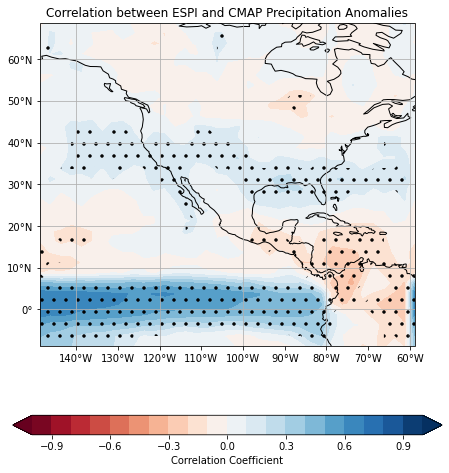

In [17]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=r_array
data,lon=add_cyclic_point(data,coord=ds_anoms['lon'])
mask_data,lons=add_cyclic_point(mask_sig,coord=ds_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='RdBu',extend='both')

ax.contourf(lon,ds_anoms['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(220,310,10),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(0,70,10),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between ESPI and CMAP Precipitation Anomalies')
plt.savefig('Correlaton-ESPI,Precip')